In [71]:
import torchvision
from torchvision import datasets

train_data = datasets.CIFAR10(
    root = 'CIFAR/',
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor()
)

test_data = datasets.CIFAR10(
    root = 'CIFAR/',
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor()
)


Text(0.5, 1.0, 'horse')

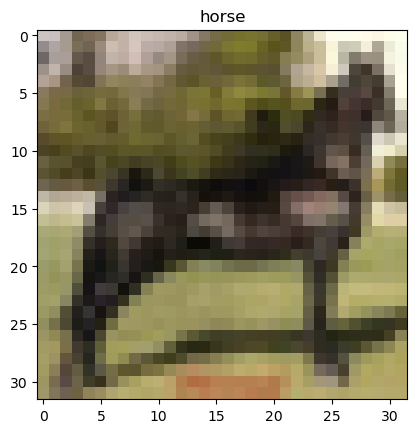

In [72]:
import matplotlib.pyplot as plt
import torch
random_image = torch.randint(0, len(train_data), size = [1]).item()
image, label = train_data[random_image]
class_names = train_data.classes
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.title(class_names[label])

In [73]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

# Prepare Dataloader

In [75]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle =False)
len(train_dataloader), len(test_dataloader)

(782, 157)

In [79]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

(-0.5, 31.5, 31.5, -0.5)

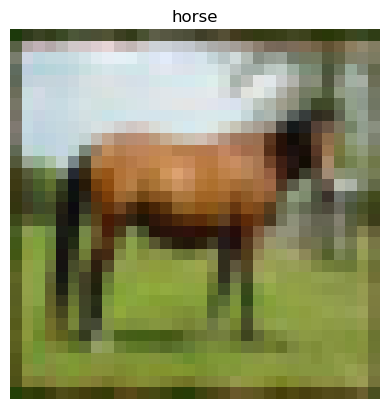

In [81]:
random_batch_image_idx = torch.randint(0, len(train_feature_batch), size = [1]).item()
image, label = train_feature_batch[random_batch_image_idx], train_label_batch[random_batch_image_idx]
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

# Building Model

In [860]:
from torch import nn
class CIFARMODEL(nn.Module):
    def __init__(self, input_features: int, output_features: int, hidden_features: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = hidden_features,
                      out_channels = hidden_features,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_features * 4 * 4,
                      out_features = hidden_features),
            nn.Dropout(0.4),
            nn.Linear(in_features = hidden_features,
                      out_features = output_features),

        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"Output shape after passing Conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape after passing Conv block 2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape after passing Classifier: {x.shape}")
        return x
                      
        

In [863]:
model

CIFARMODEL(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, str

In [135]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [137]:
model = CIFARMODEL(input_features = 3,
                   hidden_features = 32,
                   output_features = len(class_names)).to(device)

In [141]:
image = train_feature_batch[0].to(device)


In [143]:
image.shape

torch.Size([3, 32, 32])

In [145]:
512/ 32

16.0

In [147]:
dummy_y = model(image.unsqueeze(0))

In [149]:
dummy_y = torch.sigmoid(dummy_y)
dummy_y.shape

torch.Size([1, 10])

In [151]:
label_y = torch.argmax(dummy_y)

In [153]:
label_y

tensor(0, device='cuda:0')

# Loss function and Optimizer

In [168]:
# Loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.01)

In [113]:
from timeit import default_timer as timer
def print_time(start: float,
               end: float,
               device: torch.device = None):
    total_time = end - start
    print(f"Total time on {device}: {total_time: .3f} seconds")
    return total_time

In [115]:
start_time = timer()

end_time = timer()
print_time(start = start_time, end = end_time, device = 'cuda')

Total time on cuda:  0.000 seconds


1.7600017599761486e-05

In [117]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Training and Testing loop

In [170]:
start_time = timer()

EPOCHS = 5
epoch_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0

    print(f"Epochs: {epoch + 1} / {EPOCHS} \n----")
    for batch, (X, y) in enumerate(train_dataloader):
        y = y.to(device)
        X = X.to(device)
        # Training
        model.train()

        # Forward Pass
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true = y,
                                 y_pred = y_pred)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backwards
        loss.backward()

        # Optimizer step
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Testing
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                # Forward pass
                test_logits = model(X_test)
                test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
                # Test loss
                test_loss += loss_fn(test_logits, 
                                     y_test)
                test_acc += accuracy_fn(y_true = y_test,
                                        y_pred = test_pred)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    #Print out whats happening
    epoch_count.append(epoch)
    loss_values.append(train_loss)
    test_loss_values.append(test_loss)
    acc_values.append(train_acc)
    test_acc_values.append(test_acc)
    print(f"Epoch: {epoch + 1} | Train loss: {train_loss} | Train accuracy: {train_acc} | Test loss: {test_loss} | Test accuracy: {test_acc}\n")

end_time = timer()
print_time(start = start_time,
           end = end_time)

Epochs: 1 / 5 
----
Looked at 0 / 50000 samples
Looked at 25600 / 50000 samples
Epoch: 1 | Train loss: 0.32471972703933716 | Train accuracy: 88.81873401534527 | Test loss: 0.685353696346283 | Test accuracy: 78.70222929936305

Epochs: 2 / 5 
----
Looked at 0 / 50000 samples
Looked at 25600 / 50000 samples
Epoch: 2 | Train loss: 0.3215925693511963 | Train accuracy: 88.91464194373401 | Test loss: 0.6903479099273682 | Test accuracy: 78.35390127388536

Epochs: 3 / 5 
----
Looked at 0 / 50000 samples
Looked at 25600 / 50000 samples
Epoch: 3 | Train loss: 0.3169815242290497 | Train accuracy: 89.01054987212277 | Test loss: 0.6950499415397644 | Test accuracy: 78.68232484076434

Epochs: 4 / 5 
----
Looked at 0 / 50000 samples
Looked at 25600 / 50000 samples
Epoch: 4 | Train loss: 0.3163577616214752 | Train accuracy: 88.95060741687979 | Test loss: 0.7011992335319519 | Test accuracy: 78.47332802547771

Epochs: 5 / 5 
----
Looked at 0 / 50000 samples
Looked at 25600 / 50000 samples
Epoch: 5 | Train

115.8468409999914

In [240]:
print(f"Train loss: {train_loss} | Train accuracy: {train_acc}")
print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")

Train loss: 0.36166685819625854 | Train accuracy: 85.9375
Test loss: 0.7036648988723755 | Test accuracy: 78.59275477707007


In [242]:
test_pred.squeeze()

tensor([7, 3, 8, 0, 8, 4, 7, 0, 3, 5, 3, 8, 6, 5, 1, 7], device='cuda:0')

In [661]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample
            sample = torch.unsqueeze(sample, dim = 0).to(device)

        # Forward pass
            pred_logit = model(sample)

        # Get pred probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

        # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack pred_probs to turn list into tensor
    return torch.stack(pred_probs)

In [662]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)
    #View the firs sample shape
test_samples[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'truck')

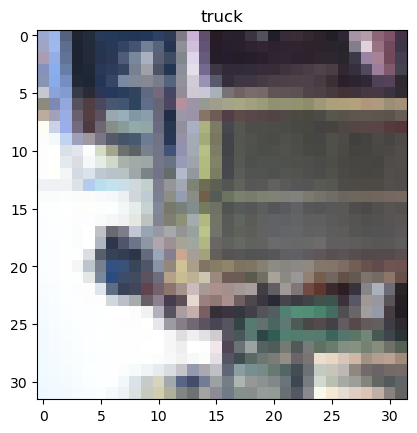

In [663]:
plt.imshow(test_samples[0].T.squeeze())
plt.title(class_names[test_labels[0]])

In [664]:
# Make predictions
pred_probs = make_predictions(model = model,
                              data = test_samples)

# View first two predictions
pred_probs[:2]

tensor([[0.1012, 0.1002, 0.0752, 0.0792, 0.0542, 0.0743, 0.0444, 0.1267, 0.0764,
         0.2683],
        [0.1077, 0.0431, 0.1428, 0.1020, 0.1206, 0.0914, 0.1000, 0.1629, 0.0432,
         0.0864]])

In [666]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([9, 7, 7, 2, 7, 7, 0, 3, 6])

<function matplotlib.pyplot.show(close=None, block=None)>

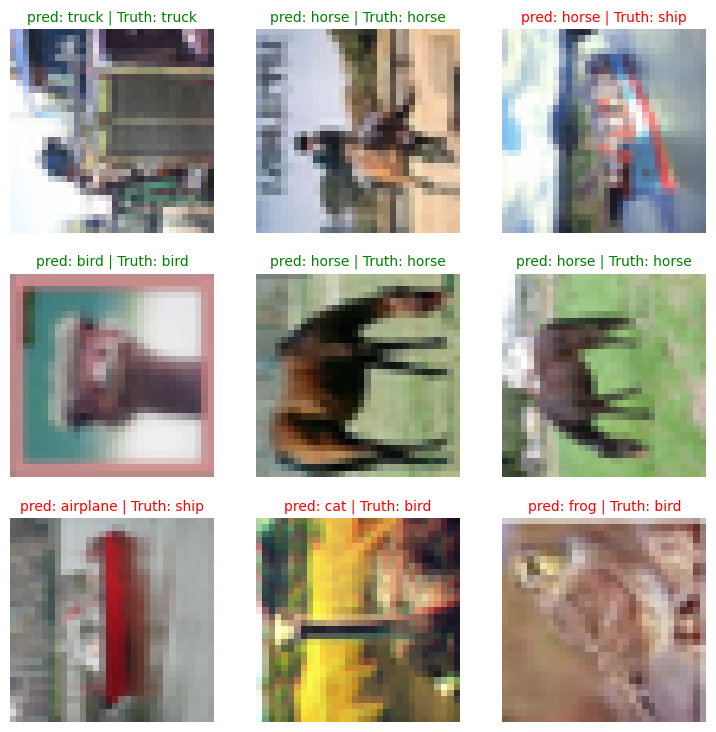

In [667]:
#plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    #create subplot
    plt.subplot(nrows, ncols, i + 1)

    # plot the target image
    plt.imshow(sample.T.squeeze())

    # Find pred labels 
    pred_label = class_names[pred_classes[i]]

    # Get truth label
    truth_label = class_names[test_labels[i]]

    # Create title for the plot
    title_text = f"pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize = 10, c = "g")
    else:
        plt.title(title_text, fontsize = 10, c = "r")

    plt.axis(False)
               
plt.show

# Save and load model

In [204]:
from pathlib import Path
# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)
MODEL_NAME = "CIFAR_CNN.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH
          )

Saving model to: models\CIFAR_CNN.pth
